In [1]:
import os 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
import keras
from keras import backend as K
from keras import initializers

In [2]:
# K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

latent_dim = 10
# 10 works better here, 100 is for the consistency with other GAN implementations

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

adam = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [3]:
generator = Sequential()

generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 28, 28)        0

In [4]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

print(discriminator.summary())

discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [5]:
discriminator.trainable = False
ganInput = Input(shape=(latent_dim, ))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [6]:
dLosses = [ ]
gLosses = []

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminative Loss')
    plt.plot(gLosses, label='Generative Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):

    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)

    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()

# def saveModels(epoch):
#     generator.save('')
#     discrimantor.save('')

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 20
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 1/468 [00:00<00:56,  8.21it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/468 [00:00<00:50,  9.20it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/468 [00:00<00:49,  9.36it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/468 [00:00<00:51,  9.04it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/468 [00:00<00:58,  8.03it/s]

--------------- Epoch 6 ---------------


  0%|          | 1/468 [00:00<00:52,  8.91it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/468 [00:00<00:50,  9.25it/s]

--------------- Epoch 8 ---------------


  0%|          | 1/468 [00:00<00:51,  9.08it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/468 [00:00<00:50,  9.18it/s]

--------------- Epoch 10 ---------------


  0%|          | 1/468 [00:00<00:53,  8.78it/s]

--------------- Epoch 11 ---------------


  0%|          | 1/468 [00:00<00:54,  8.55it/s]

--------------- Epoch 12 ---------------


  0%|          | 1/468 [00:00<00:49,  9.37it/s]

--------------- Epoch 13 ---------------


  0%|          | 1/468 [00:00<00:53,  8.69it/s]

--------------- Epoch 14 ---------------


  0%|          | 1/468 [00:00<00:51,  8.98it/s]

--------------- Epoch 15 ---------------


  0%|          | 1/468 [00:00<00:54,  8.60it/s]

--------------- Epoch 16 ---------------


  0%|          | 1/468 [00:00<00:54,  8.50it/s]

--------------- Epoch 17 ---------------


  0%|          | 1/468 [00:00<00:50,  9.18it/s]

--------------- Epoch 18 ---------------


  0%|          | 1/468 [00:00<00:52,  8.96it/s]

--------------- Epoch 19 ---------------


  0%|          | 1/468 [00:00<00:50,  9.30it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:52<00:00,  8.84it/s]


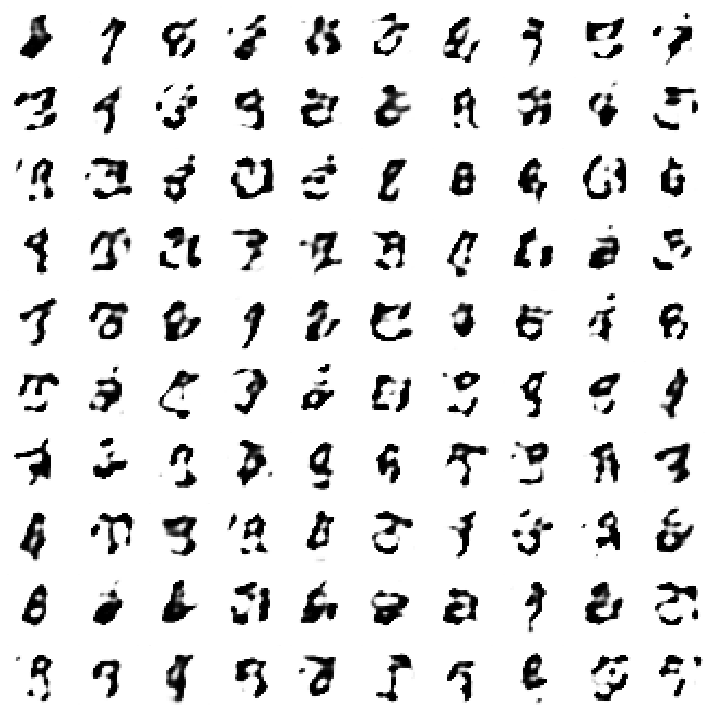

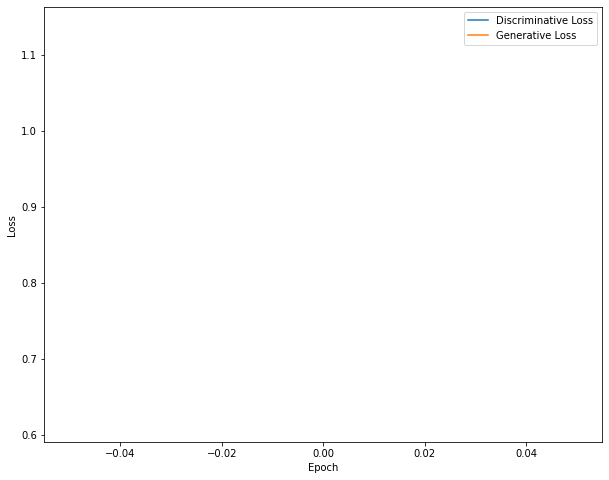

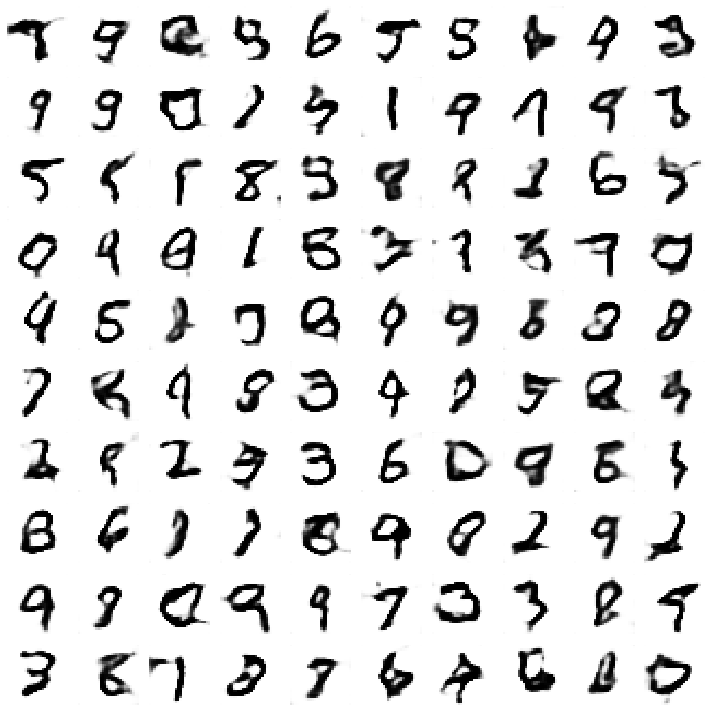

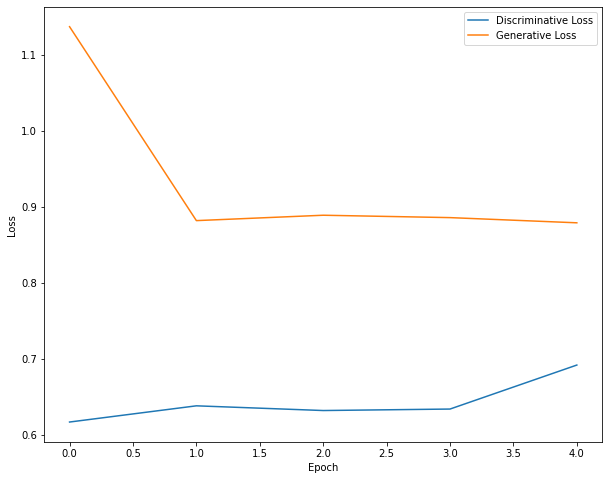

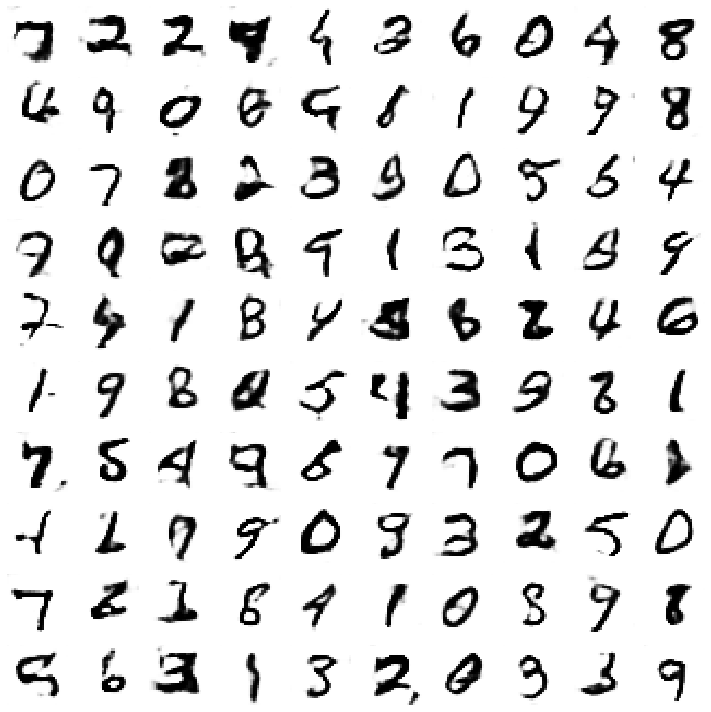

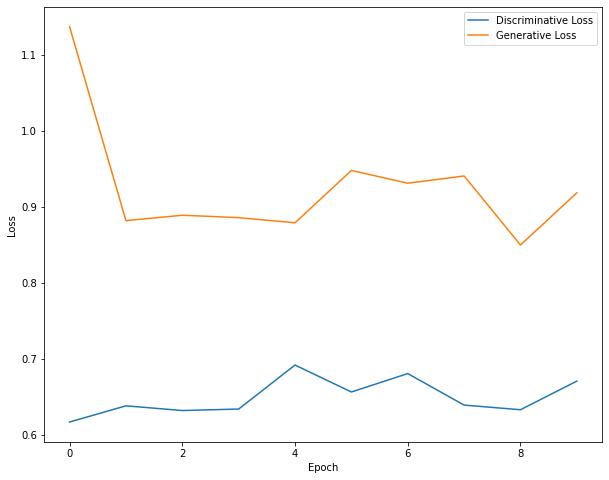

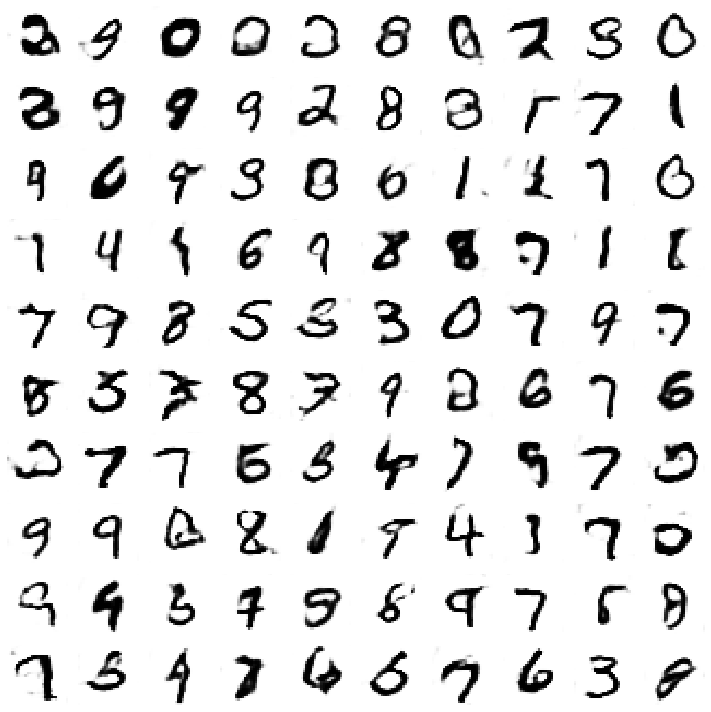

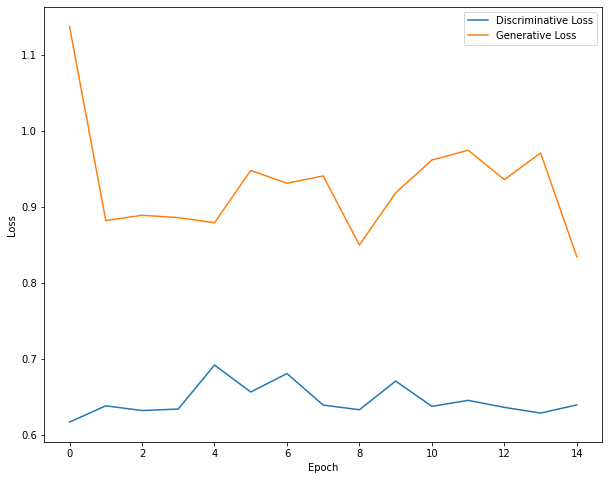

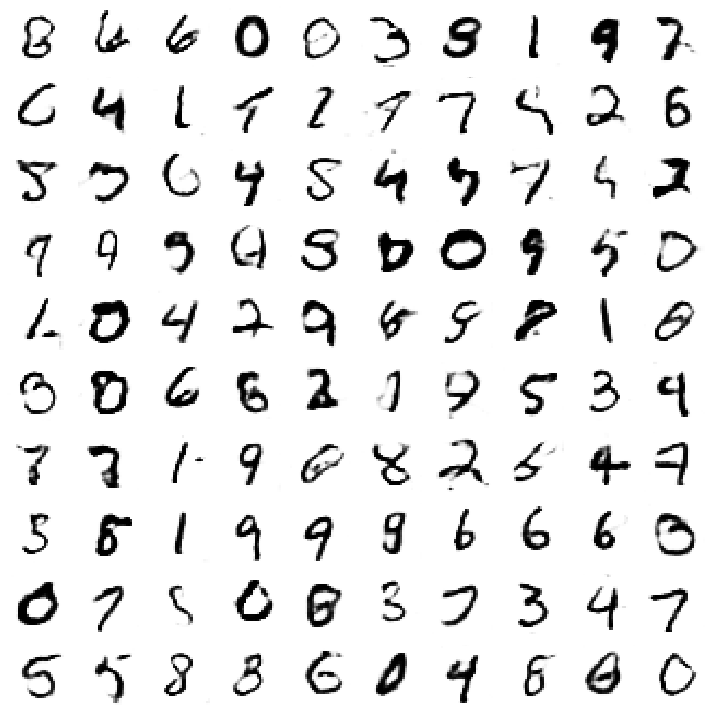

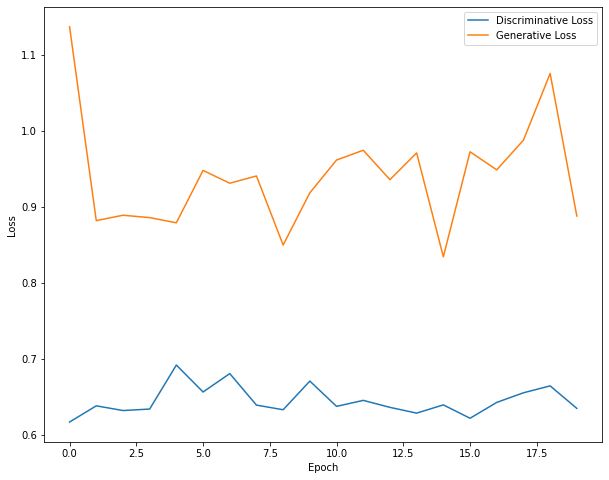

In [7]:
epochs = 20
batchSize = 128
batchCount = X_train.shape[0] / batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):

    print('-' * 15, 'Epoch %d' % e, '-' * 15)

    for i in tqdm(range(int(batchCount))):

        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        yDis = np.zeros(2 * batchSize)
        yDis[:batchSize] = 0.9

        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    dLosses.append(dloss)
    gLosses.append(gloss)

    if e==1 or e%5 == 0:
        plotGeneratedImages(e)
        plotLoss(e)